In [1]:
# pip install google-adk

In [5]:
import credentials
import os

In [6]:
GOOGLE_API_KEY = credentials.GOOGLE_API_KEY
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [7]:
from google.adk.agents import Agent
from google.adk.models.google_llm import Gemini
from google.adk.runners import InMemoryRunner
from google.adk.tools import google_search
from google.genai import types

print("✅ ADK components imported successfully.")

✅ ADK components imported successfully.


In [8]:
retry_config=types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1, # Initial delay before first retry (in seconds)
    http_status_codes=[429, 500, 503, 504] # Retry on these HTTP errors
)

In [9]:
root_agent = Agent(
    name="helpful_assistant",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    description="A simple agent that can answer general questions.",
    instruction="You are a helpful assistant. Use Google Search for current info or if unsure.",
    tools=[google_search],
)

print("✅ Root Agent defined.")

✅ Root Agent defined.


In [10]:
runner = InMemoryRunner(agent=root_agent)

print("✅ Runner created.")

✅ Runner created.


In [11]:
response = await runner.run_debug(
    "What is Agent Development Kit from Google? What languages is the SDK available in?"
)


 ### Created new session: debug_session_id

User > What is Agent Development Kit from Google? What languages is the SDK available in?
helpful_assistant > The Agent Development Kit (ADK) from Google is a flexible, modular, open-source framework designed to simplify the development, deployment, and orchestration of AI agents and multi-agent systems. It applies software development principles to AI agent creation, allowing developers to define agent behavior, orchestration, and tool use directly in code. This approach enables robust debugging, versioning, and deployment flexibility, allowing agents to run anywhere from a laptop to the cloud. While optimized for Google's Gemini models and ecosystem, ADK is model-agnostic and compatible with other frameworks.

The ADK SDK is available in the following languages:
*   **Python**
*   **Java**
*   **Go**


In [12]:
# multi step workflows
from google.adk.agents import Agent, SequentialAgent, ParallelAgent, LoopAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import InMemoryRunner
from google.adk.tools import AgentTool, FunctionTool, google_search
from google.genai import types

print("✅ ADK components imported successfully.")

✅ ADK components imported successfully.


In [13]:
retry_config=types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504], # Retry on these HTTP errors
)

## Architecture: Single Agent vs Multi-Agent Team

### Multi-agent Team

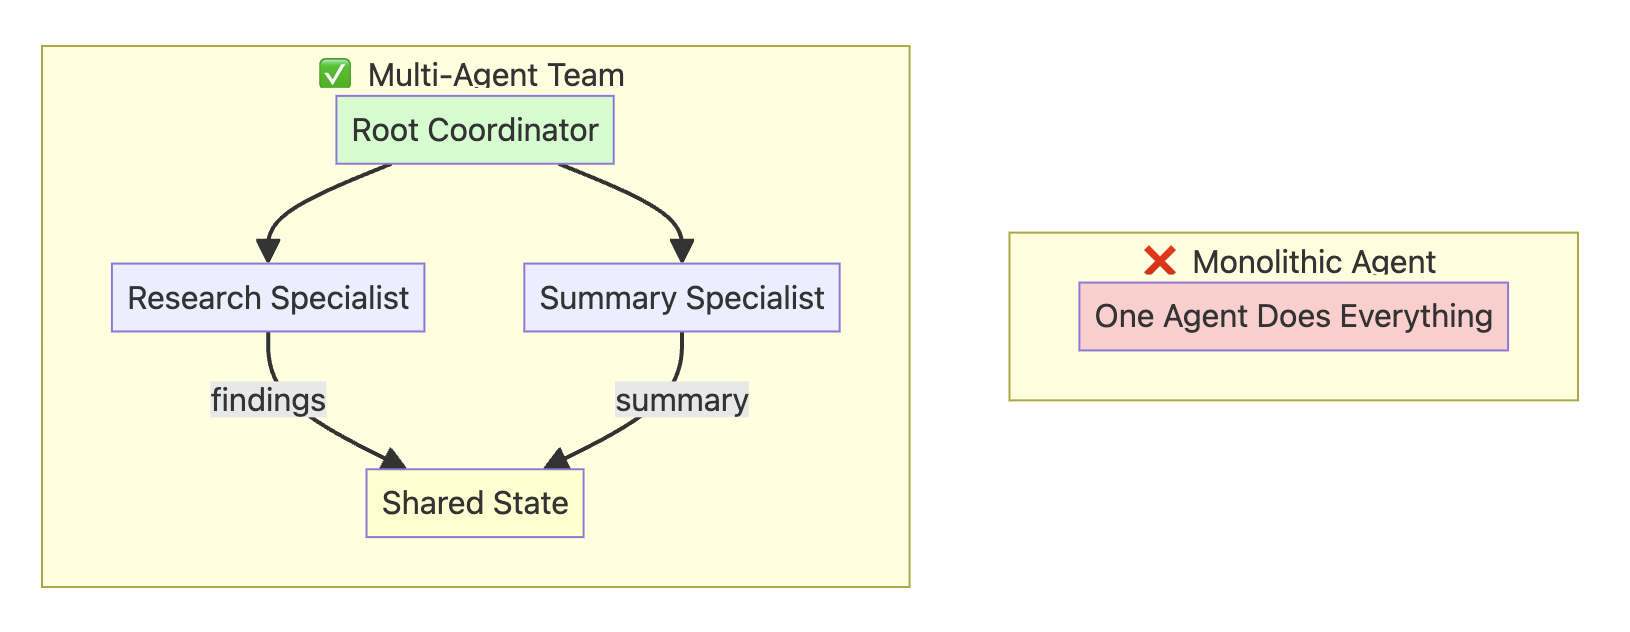

In [14]:
# Research Agent: Its job is to use the google_search tool and present findings.
research_agent = Agent(
    name="ResearchAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""You are a specialized research agent. Your only job is to use the
    google_search tool to find 2-3 pieces of relevant information on the given topic and present the findings with citations.""",
    tools=[google_search],
    output_key="research_findings",  # The result of this agent will be stored in the session state with this key.
)

print("✅ research_agent created.")

✅ research_agent created.


In [15]:
# Summarizer Agent: Its job is to summarize the text it receives.
summarizer_agent = Agent(
    name="SummarizerAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    # The instruction is modified to request a bulleted list for a clear output format.
    instruction="""Read the provided research findings: {research_findings}
Create a concise summary as a bulleted list with 3-5 key points.""",
    output_key="final_summary",
)

print("✅ summarizer_agent created.")

✅ summarizer_agent created.


In [16]:
# Root Coordinator: Orchestrates the workflow by calling the sub-agents as tools.
root_agent = Agent(
    name="ResearchCoordinator",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    # This instruction tells the root agent HOW to use its tools (which are the other agents).
    instruction="""You are a research coordinator. Your goal is to answer the user's query by orchestrating a workflow.
1. First, you MUST call the `ResearchAgent` tool to find relevant information on the topic provided by the user.
2. Next, after receiving the research findings, you MUST call the `SummarizerAgent` tool to create a concise summary.
3. Finally, present the final summary clearly to the user as your response.""",
    # We wrap the sub-agents in `AgentTool` to make them callable tools for the root agent.
    tools=[AgentTool(research_agent), AgentTool(summarizer_agent)],
)

print("✅ root_agent created.")

✅ root_agent created.


In [17]:
runner = InMemoryRunner(agent=root_agent)
response = await runner.run_debug(
    "What are the latest advancements in quantum computing and what do they mean for AI?"
)


 ### Created new session: debug_session_id

User > What are the latest advancements in quantum computing and what do they mean for AI?


ResearchCoordinator > Here's a concise summary of the latest advancements in quantum computing and their implications for AI:

*   **Revolutionary Computational Power for AI:** Quantum computing, through principles like superposition and entanglement, offers exponential speedups, promising to accelerate AI model training, enhance optimization capabilities, and enable processing of vast datasets far more efficiently than classical computers.
*   **Near-Term Practical Applications & Hybrid Approaches:** While widespread adoption is years away, practical Quantum AI applications are expected by the late 2020s, likely starting with hybrid models that combine quantum and classical computing strengths.
*   **Significant Energy Efficiency & Broad Industry Impact:** Quantum AI demonstrates potential for drastic reductions in energy consumption for AI tasks and is poised to transform sectors like healthcare, finance, cybersecurity, manufacturing, and transportation.
*   **Ongoing Challenges & Ac

Use Sequential when: Order matters, you need a linear pipeline, or each step builds on the previous one.

To learn more, check out the documentation related to sequential agents in ADK.

## Architecture: Blog Post Creation Pipeline

### Sequential Agent

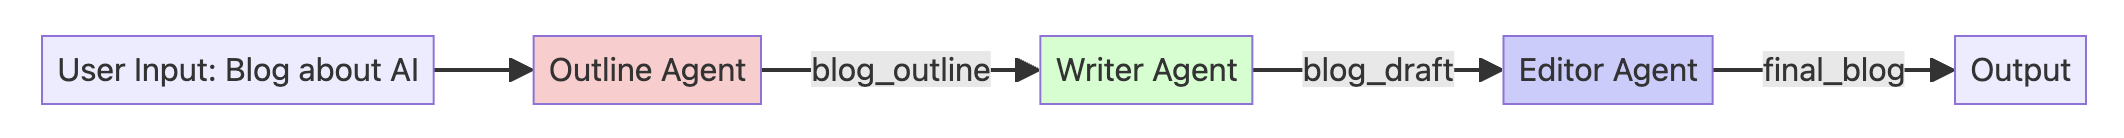

In [18]:
# Outline Agent: Creates the initial blog post outline.
outline_agent = Agent(
    name="OutlineAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""Create a blog outline for the given topic with:
    1. A catchy headline
    2. An introduction hook
    3. 3-5 main sections with 2-3 bullet points for each
    4. A concluding thought""",
    output_key="blog_outline",  # The result of this agent will be stored in the session state with this key.
)

print("✅ outline_agent created.")

✅ outline_agent created.


In [19]:
# Writer Agent: Writes the full blog post based on the outline from the previous agent.
writer_agent = Agent(
    name="WriterAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    # The `{blog_outline}` placeholder automatically injects the state value from the previous agent's output.
    instruction="""Following this outline strictly: {blog_outline}
    Write a brief, 200 to 300-word blog post with an engaging and informative tone.""",
    output_key="blog_draft",  # The result of this agent will be stored with this key.
)

print("✅ writer_agent created.")

✅ writer_agent created.


In [20]:
# Editor Agent: Edits and polishes the draft from the writer agent.
editor_agent = Agent(
    name="EditorAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    # This agent receives the `{blog_draft}` from the writer agent's output.
    instruction="""Edit this draft: {blog_draft}
    Your task is to polish the text by fixing any grammatical errors, improving the flow and sentence structure, and enhancing overall clarity.""",
    output_key="final_blog",  # This is the final output of the entire pipeline.
)

print("✅ editor_agent created.")

✅ editor_agent created.


In [21]:
root_agent = SequentialAgent(
    name="BlogPipeline",
    sub_agents=[outline_agent, writer_agent, editor_agent],
)

print("✅ Sequential Agent created.")

✅ Sequential Agent created.


In [22]:
runner = InMemoryRunner(agent=root_agent)
response = await runner.run_debug(
    "Write a blog post about the benefits of multi-agent systems for software developers"
)


 ### Created new session: debug_session_id

User > Write a blog post about the benefits of multi-agent systems for software developers
OutlineAgent > ## Blog Outline: Multi-Agent Systems for Software Developers

**1. Headline:** Beyond Monoliths: Unleashing the Power of Multi-Agent Systems for Smarter Software

**2. Introduction Hook:**
    * Are you tired of complex, monolithic codebases that are a nightmare to maintain and scale?
    * Imagine a software architecture where independent, intelligent "agents" collaborate to achieve complex tasks, making your development process more agile and your applications more robust. This isn't science fiction – it's the promise of Multi-Agent Systems (MAS).

**3. Main Sections:**

    *   **Section 1: What Exactly are Multi-Agent Systems (and Why Should You Care)?**
        *   **Definition:** Briefly explain MAS as a system composed of multiple interacting intelligent agents, each with its own goals and capabilities.
        *   **Core Concepts

## Parallel Workflows

### Architecture: Multi-Topic Research

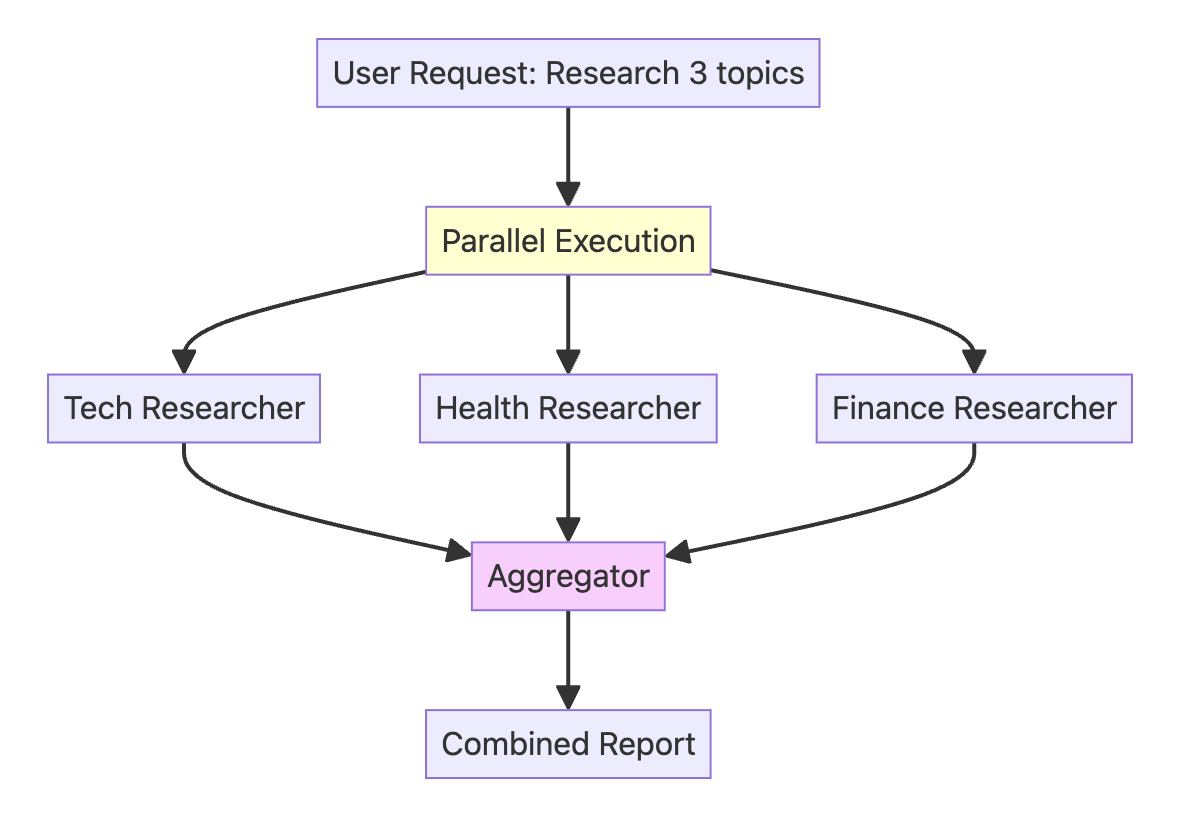

In [24]:
# Tech Researcher: Focuses on AI and ML trends.
tech_researcher = Agent(
    name="TechResearcher",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""Research the latest AI/ML trends. Include 3 key developments,
the main companies involved, and the potential impact. Keep the report very concise (100 words).""",
    tools=[google_search],
    output_key="tech_research",  # The result of this agent will be stored in the session state with this key.
)

print("✅ tech_researcher created.")

✅ tech_researcher created.


In [25]:
# Health Researcher: Focuses on medical breakthroughs.
health_researcher = Agent(
    name="HealthResearcher",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""Research recent medical breakthroughs. Include 3 significant advances,
their practical applications, and estimated timelines. Keep the report concise (100 words).""",
    tools=[google_search],
    output_key="health_research",  # The result will be stored with this key.
)

print("✅ health_researcher created.")

✅ health_researcher created.


In [26]:
# Finance Researcher: Focuses on fintech trends.
finance_researcher = Agent(
    name="FinanceResearcher",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""Research current fintech trends. Include 3 key trends,
their market implications, and the future outlook. Keep the report concise (100 words).""",
    tools=[google_search],
    output_key="finance_research",  # The result will be stored with this key.
)

print("✅ finance_researcher created.")

✅ finance_researcher created.


In [27]:
# The AggregatorAgent runs *after* the parallel step to synthesize the results.
aggregator_agent = Agent(
    name="AggregatorAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    # It uses placeholders to inject the outputs from the parallel agents, which are now in the session state.
    instruction="""Combine these three research findings into a single executive summary:

    **Technology Trends:**
    {tech_research}
    
    **Health Breakthroughs:**
    {health_research}
    
    **Finance Innovations:**
    {finance_research}
    
    Your summary should highlight common themes, surprising connections, and the most important key takeaways from all three reports. The final summary should be around 200 words.""",
    output_key="executive_summary",  # This will be the final output of the entire system.
)

print("✅ aggregator_agent created.")

✅ aggregator_agent created.


In [28]:
# The ParallelAgent runs all its sub-agents simultaneously.
parallel_research_team = ParallelAgent(
    name="ParallelResearchTeam",
    sub_agents=[tech_researcher, health_researcher, finance_researcher],
)

# This SequentialAgent defines the high-level workflow: run the parallel team first, then run the aggregator.
root_agent = SequentialAgent(
    name="ResearchSystem",
    sub_agents=[parallel_research_team, aggregator_agent],
)

print("✅ Parallel and Sequential Agents created.")

✅ Parallel and Sequential Agents created.


In [29]:
runner = InMemoryRunner(agent=root_agent)
response = await runner.run_debug(
    "Run the daily executive briefing on Tech, Health, and Finance"
)


 ### Created new session: debug_session_id

User > Run the daily executive briefing on Tech, Health, and Finance
HealthResearcher > Here's a summary of recent breakthroughs across Tech, Health, and Finance:

**Health:**
1.  **Pig-to-Human Organ Transplants:** Genetically modified pig organs are being successfully transplanted into humans, offering hope for organ transplant waitlists. This is currently in advanced trial stages with potential widespread application in the next 2-5 years.
2.  **AI-Enhanced Diagnostics:** AI is significantly improving the accuracy of medical diagnostics, such as mammograms and Alzheimer's blood tests. These are rapidly being integrated, with broad clinical adoption expected within 1-3 years.
3.  **Non-Opioid Pain Relievers:** New non-opioid pain management drugs are showing promise in late-stage trials, aiming to provide alternatives to addictive painkillers. Expected market availability within 2-4 years.

**Technology:**
1.  **Agentic AI:** AI systems th